## Compare occupancy of each degradation factor with various transcript features (length, half-life, optimality, expression)

#### correlation analysis and feature importance analysis

In [1]:
import pybedtools 
import sys
import numpy as np
import pandas as pd
import os
import glob
import math
import matplotlib.pyplot as plt
import re
from scipy.optimize import curve_fit
import pybedtools 
from pybedtools.bedtool import BedTool
from collections import deque
from bisect import insort, bisect_left
from itertools import islice
from scipy.stats import gaussian_kde
from scipy import stats
from pandas.plotting import scatter_matrix
import seaborn as sns
sns.set_style('ticks')
from scipy.stats import pearsonr

#### set these variables

In [2]:
home_dir = '/home/salma/Coding/scratch/'

pipeline_dir = os.path.join(home_dir, 'pipeline')
plotting_dir = os.path.join(home_dir, 'plots/occupancy_vs_features')

pathways_of_interest = ['NMD', 'Deadenylation', 'Decapping', 'TRAMP', 'Ski', 'Exosome', 'Xrn1']

In [3]:
#load data list
data_summary = pd.read_table(os.path.join(home_dir, 'data_summary_detailed.txt'), header=None)
data_summary.columns=['factor', 'pathway', 'group']
data_summary.index = data_summary.factor

factors = data_summary.loc[data_summary.pathway.isin(pathways_of_interest), 'factor']

#### Load occupancies, and transcript features over the previously assembled annotation

In [4]:
#build a matrix based on the Occupancies, previously calculated by cluster
# to see how it was built:
# /usr/users/ssohrab/CLIP/scripts/occupancy_allTranscripts_helper.py
# hint: it sums occupancies of xl sites falling into each transcript (based on steinmetz_transcripts_tifs_clean_sorted.gff)

occupancy = list()
for dir_occ in glob.glob(os.path.join(home_dir,'analysis','occupancy_mRNAs','*.txt')):
    with open(dir_occ, 'r') as f:
        occupancy.append([float(i) for i in f.readlines()[0].split()])

factor_name = [os.path.basename(d).split('.')[0] for d in glob.glob(os.path.join(home_dir,'analysis','occupancy_mRNAs','*.txt'))]
factor_name = [s.split('_')[0] for s in factor_name]

occupancy = pd.DataFrame(occupancy).transpose()
occupancy.columns = factor_name

In [5]:
# read coverage for expression level

coverage_path = os.path.join(home_dir, 'Annotations/salma/coverage_tifs.bed')
coverage = pd.read_table(coverage_path, sep='\t', header= None)

coverage.columns = ['chr','source','type','start','end','c1','strand','c2', 'name', 'coverage']

coverage['length'] = coverage.end - coverage.start

In [6]:
#load the file that has the half life attributes

f = os.path.join(home_dir, "additional_files/bjoern/cerevisiae_with_halflives.txt")

#half-life is associated with gene-name: need reassognment to our coordinates
anno = pd.read_table(f, sep='\t')
mRNA = pd.read_table( os.path.join(home_dir, "Annotations/steinmetz_transcripts_tifs_clean_sorted.gff") ,
                     sep='\t', header=None)
mRNA['name'] = mRNA.iloc[:,8].values
mRNA['half_lives'] = np.zeros(len(mRNA))

for i in range(len(mRNA)):
    if (mRNA.name[i] in anno.name.values):
        mRNA.iloc[i,10] = anno.loc[anno.name.isin([mRNA.name[i]])].iloc[0,0]

coverage['halflife'] = mRNA.half_lives.values

In [7]:
#calculate optimality of transcripts

#make fasta file for ORFs
# bedtools getfasta -s -fi ~/CLIP/Reference_genome/WholeGenomeFasta/genome.fa -bed 
# ~/CLIP/Annotations/R64-2-1_CDS.gff > ~/CLIP/additional_files/nonoverlap_ORFs.fa

#estimate codon optimality for each transcript
opt_table = os.path.join(home_dir,'additional_files/codon_optimality_normalizedTE.txt')
#opt_table = os.path.join(home_dir,'additional_files/codon_optimality_classicalTE.txt')

codon_fromfile = pd.read_table(opt_table, 
                               comment='#', index_col=0)
optimality = codon_fromfile.to_dict()['Scer']
optimality['TAA'] = optimality['TAG'] = optimality['TGA'] =0

def fasta_parser(filename):
    with open(filename, 'r') as f:
        s = f.readlines()
    return list(map(str.rstrip, s[1::2]))

seqs = fasta_parser(os.path.join(home_dir, 'additional_files/nonoverlap_ORFs.fa'))

transcript_opts = []
for seq in seqs:
    try:
        opt = 0
        for i in range(0, len(seq), 3):
            opt += optimality[seq[i:i+3]]
        opt /= (len(seq)/3 -1)
        transcript_opts.append(opt)
    except:
        transcript_opts.append('NA')

CDs_df = pd.read_table(os.path.join(home_dir, 'Annotations/R64-2-1_CDS.gff'), header=None)
CDs_df[9] = transcript_opts
CDs_anno = BedTool.from_dataframe(CDs_df)

coverage_bed = BedTool.from_dataframe(coverage)

c = coverage_bed.intersect(CDs_anno, s=True, wao=True)

mapped_df = c.to_dataframe(names=['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'coverage',
                                  'length', 'halflife', 'chrom2', 'source2', 'name2', 'start2', 'end2',
                                  'score2', 'strand2', 'thickStart2', 'random', 'optimality', 'overlap'])
mapped_df = mapped_df.drop_duplicates(subset=['chrom', 'start', 'end'], keep='last', inplace=False)
print(len(mapped_df))
print(len(coverage))
coverage = mapped_df.loc[:, ['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'coverage',
                                  'length', 'halflife', 'optimality']]

5578
5578


In [8]:
#load the file with poly-(A) length

f = os.path.join(home_dir, "additional_files/polyA_length_GSE52809_Cerevisiae_cytosol.txt")
polyA = pd.read_table(f, sep='\t')
mRNA = pd.read_table( os.path.join(home_dir, "Annotations/salma/rest_features_old.bed") ,\
                     sep='\t', header=None)
mRNA = pd.read_table( os.path.join(home_dir, "Annotations/steinmetz_transcripts_tifs_clean_sorted.gff") ,
                     sep='\t', header=None)
mRNA['name'] = mRNA.iloc[:,8].values
mRNA['polyA'] = np.zeros(len(mRNA))

for i in range(len(mRNA)):
    if (mRNA.name[i] in polyA.gene.values):
        mRNA.iloc[i,10] = polyA.loc[polyA.gene.isin([mRNA.name[i]])].iloc[0,1]

coverage['polyA'] = mRNA.polyA.values

In [9]:
coverage['gene_name'] = mRNA.name.values
occupancy['gene_name'] = mRNA.name.values
occupancy['length'] = coverage.length.values
occupancy['halflife'] = coverage.halflife.values
occupancy['coverage'] = coverage.coverage.values/occupancy.length.values
occupancy['optimality'] = coverage.optimality.values
occupancy['polyA'] = coverage.polyA.values

In [10]:
#filter a 90% interval when drawing the correlation plots

occupancy2 = occupancy.loc[occupancy.halflife>0].copy()
start = occupancy2.quantile(.05, axis=0)[-5:]
end = occupancy2.quantile(.95, axis=0)[-5:]

### Helper functions

In [11]:
def running_median_insort(seq, window_size):
    """Contributed by Peter Otten"""
    seq = iter(seq)
    d = deque()
    s = []
    result = []
    for item in islice(seq, window_size):
        d.append(item)
        insort(s, item)
        result.append(s[len(d)//2])
    m = window_size // 2
    for item in seq:
        old = d.popleft()
        d.append(item)
        del s[bisect_left(s, old)]
        insort(s, item)
        result.append(s[m])
    return result

In [12]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [13]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [14]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    return r

In [15]:
def bootstrap(occupancy, factor, feature, n=1000, sm=0, ci=0.05):
    ser = []
    for i in range(n):
        data_sub = occupancy.loc[:,[factor,feature]]
        rows=np.random.randint(0, len(occupancy.index), size=len(occupancy.index))
        data_sub = data_sub.iloc[rows,:].sort_values([feature],ascending=[True])
        data = data_sub[factor].values
        feat = data_sub[feature].values
        if sm>0:
            smoothing_window = sm
        else:
            smoothing_window = int(len(data)/80)*2 + 2
        med = running_mean(data,smoothing_window)
        ser.append(med)
    ser = pd.DataFrame(ser)
    return ser.quantile(ci), ser.quantile(1-ci)


In [16]:
#plot lines with bootstrapping
def plot_line_bs(data_table, feature, title, plot_name, filter_pos=False, face_col=True, line_color=False, lin_fit=False, xlim=None):
    plt.figure(figsize=(10,14))
    plt.suptitle('Factor occupancy for transcripts by '+title, fontsize = 14, y = 0.93)

    for i, factor in enumerate(factors):
        low_int, high_int = bootstrap(data_table, factor, feature)
        if filter_pos:
            #filter positive values
            data = [x for x in data_table[factors[i]].values if (x>0)]

            pos_inx = data_table.loc[data_table[factors[i]]>0,:].index
            feat = [data_table.loc[inx, feature] for inx in pos_inx]
        else:
            data = data_table[factors[i]].values
            feat = data_table[feature].values

        smoothing_window = int(len(data)/80)*2 + 2
        #med = running_median_insort(data,smoothing_window)
        med = running_mean(data,smoothing_window)

        ax1 = plt.subplot(8,4,i+1)

        if lin_fit:
            x=feat[int(smoothing_window/2):-int(smoothing_window/2)+1]
            fit = np.polyfit(x, med, 1)
            fit_fn = np.poly1d(fit) 
            
            # fit_fn is now a function which takes in x and returns an estimate for y
            plt.plot(x, fit_fn(x), '--r')
        
        ax1.plot(feat[int(smoothing_window/2):-int(smoothing_window/2)+1], med,
                 linewidth = 0.5, color = pw_colors[i] if line_color else 'black')
        ax1.plot(feat[int(smoothing_window/2):-int(smoothing_window/2)+1], low_int,
                 linewidth = 0.1, color = 'grey')
        ax1.plot(feat[int(smoothing_window/2):-int(smoothing_window/2)+1], high_int,
                 linewidth = 0.1, color = 'grey')
        ax1.fill_between(feat[int(smoothing_window/2):-int(smoothing_window/2)+1], low_int, high_int, facecolor='#D1CFD5', interpolate=True)
        
        ax1.legend([factors[i]], frameon = False,  handlelength=0, handletextpad=0)

        if face_col:
            ax1.patch.set_facecolor(cl_colors[i])
            ax1.patch.set_alpha(0.4)

        # Turn off tick labels
        if(i<28):
            plt.xticks([])
        #plt.yticks([])
        ax1.tick_params(labelsize = 4)
        if xlim is None:
            plt.xlim([feat[int(smoothing_window/2)],feat[-int(smoothing_window/2)+1]])
        else:
            plt.xlim(xlim)
        plt.ylim([0,max(med)*1.1])

    plt.savefig(os.path.join(plotting_dir, plot_name), bbox_inches='tight')
    plt.close()

In [17]:
#plot lines with bootstrapping
def plot_line_pathway(pathway, title, plot_name, lin_fit=True, bs=1000, save_file=True):

    factors = data_summary.loc[data_summary.pathway == pathway, 'factor']
    no_feats = 4
    wspace = 0.4
    hspace = 0.1
    f,axes = plt.subplots(len(factors), no_feats, sharex='col', figsize=(1.5*no_feats+(wspace*(no_feats-1)) , 1.5*len(factors) + hspace*(len(factors)-1)))
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    
    def plot_col(j, data_table, feature, label):
        for i, factor in enumerate(factors):
            
            low_int, high_int = bootstrap(data_table, factor, feature, sm=int(len(data_table)/40)*2 + 2, n=bs, ci=0.025)

            data = data_table[factor].values
            feat = data_table[feature].values

            smoothing_window = int(len(data)/40)*2 + 2
            med = running_mean(data,smoothing_window)
            if len(factors)>1:
                ax1 = axes[i][j]
            else:
                ax1 = axes[j]

            if feature=='length' and lin_fit:
                #linear fit
                x=feat[int(smoothing_window/2):-int(smoothing_window/2)+1]

                if False:  #dock the line at 0,0
                    matrix = np.stack([x], axis=-1)   # stack them like columns
                    coeff = np.linalg.lstsq(matrix, med)[0] 

                    model, resid = np.linalg.lstsq(matrix, med)[:2]

                    ax1.plot(x, coeff*x, '--r', zorder=20)
                    r = corrfunc(data, feat)
                    ax1.text(0.5, 0.1, "r = {:.2f}".format(r),
                        transform=ax1.transAxes)
                    
                if True: #no constraint for the linear fit
                    fit = np.polyfit(x, med, 1)
                    fit_fn = np.poly1d(fit) 
                    # fit_fn is now a function which takes in x and returns an estimate for y
                    ax1.plot(x, fit_fn(x), '--r', zorder=20)
                    r = corrfunc(data, feat)
                    ax1.text(0.5, 0.1, "r = {:.2f}".format(r),
                        transform=ax1.transAxes)
                

            if feature=='halflife' and False:
                x=feat[int(smoothing_window/2):-int(smoothing_window/2)+1]

                def func2(t, a, b):
                    return ((a/t) + b)

                popt, pcov = curve_fit(func2, x, med)
                ax1.plot(x, [func2(xd, popt[0], popt[1]) for xd in x], '--r', zorder=15, lw=1)
                ax1.plot(x, [popt[1] for xd in x], color='grey', ls='--', zorder=2)

            x = feat[int(smoothing_window/2):-int(smoothing_window/2)+1]
            #since we smooth: plot every nth dot to save space
            n=10
            ax1.plot(x[0::n], med[0::n],
                     linewidth = 1, color = '#404040')
            ax1.fill_between(x[0::n], low_int[0::n], high_int[0::n], facecolor='#D1CFD5', interpolate=True)
            if j==0:
                ax1.set_ylabel(factor+'\n occupancy \n (a.u.)', fontsize=12)
                ax1.set_yticks([0], [0])
                ax1.yaxis.set_major_locator(plt.MaxNLocator(1))
                
            else:
                ax1.set_yticks([0], ['0'])
                ax1.yaxis.set_major_locator(plt.MaxNLocator(1))
            if i==(len(factors)-1):
                ax1.set_xlabel(label, fontsize=12)

            ax1.tick_params(labelsize = 9)
            ax1.set_xlim([feat[int(smoothing_window/2)],feat[-int(smoothing_window/2)+1]])

            ax1.set_ylim([0,max(med)*1.1])
            plt.locator_params(axis='y', nticks=3)
            ax1.get_yaxis().set_label_coords(-0.13,0.5)
            ax1.spines['top'].set_visible(False)
            ax1.spines['right'].set_visible(False)
    
    plot_col(0, occupancy_by_length, 'length', label='length')
    plot_col(1, occupancy_by_optimality, 'optimality', label='optimality')
    plot_col(2, occupancy_by_expression, 'coverage', label='expression')
    plot_col(3, occupancy_by_halflife, 'halflife', label='half-life')
    #plot_col(4, occupancy_by_TL, 'polyA', label='poly-(A)\nlength')
    
    #plt.suptitle(title, fontsize = 15, va='top')

    if save_file:
        plt.savefig(os.path.join(plotting_dir, plot_name), bbox_inches='tight')

### Length

In [18]:
occupancy_by_length = occupancy.sort_values(['length'],ascending=[True]).copy()

In [ ]:
plot_line_bs(occupancy_by_length, feature='length', title='length', plot_name='length/occupancy_by_length.pdf',
          filter_pos=False, face_col=False, lin_fit=True)

### Gene Expression

In [19]:
occupancy_by_expression = occupancy.sort_values(['coverage'],ascending=[True]).copy()
occupancy_by_expression = occupancy_by_expression.loc[(occupancy_by_expression.coverage>start.coverage) & (occupancy_by_expression.coverage<end.coverage)]

In [ ]:
plot_line_bs(occupancy_by_expression, feature='coverage', title='expression', plot_name='expression/occupancy_by_expression.pdf',
          filter_pos=False, face_col=False, lin_fit=False)

### Half-life 

In [20]:
occupancy_by_halflife = occupancy.sort_values(['halflife'],ascending=[True]).copy()
occupancy_by_halflife = occupancy_by_halflife.loc[occupancy_by_halflife.halflife>0]
occupancy_by_halflife = occupancy_by_halflife.loc[(occupancy_by_halflife.halflife>start.halflife) & (occupancy_by_halflife.halflife<end.halflife)]

In [ ]:
plot_line_bs(occupancy_by_halflife, feature='halflife', title='half-life', plot_name='half_life/occupancy_by_halflife.pdf',
          filter_pos=False, face_col=False, lin_fit=False)

### Codon Optimality

In [21]:
occupancy_by_optimality = occupancy.sort_values(['optimality'],ascending=[True]).copy()
occupancy_by_optimality = occupancy_by_optimality.loc[(occupancy_by_optimality.optimality>start.optimality) & (occupancy_by_optimality.optimality<end.optimality)]

In [ ]:
plot_line_bs(occupancy_by_optimality, feature='optimality', title='codon-optimality', plot_name='optimality/occupancy_by_optimality_normalized.pdf',
          filter_pos=False, face_col=False, lin_fit=False)

### poly-(A) length

In [22]:
occupancy_by_TL = occupancy.sort_values(['polyA'],ascending=[True]).copy()
occupancy_by_TL = occupancy_by_TL.loc[(occupancy_by_TL.polyA>0)]
st = occupancy_by_TL.quantile(.05, axis=0)[-1:][0]
print('shortest length: '+str(st))
en = occupancy_by_TL.quantile(.95, axis=0)[-1:][0]
print('longest length: '+str(en))
occupancy_by_TL = occupancy_by_TL.loc[(occupancy_by_TL.polyA>st) & (occupancy_by_TL.polyA<en)]

shortest length: 13.0
longest length: 39.6


In [ ]:
plot_line_bs(occupancy_by_TL, feature='polyA', title='poly-(A) length', plot_name='polyA/occupancy_by_polyA_cytosol_median.pdf',
          filter_pos=False, face_col=False, lin_fit=False)

### plot supplementary figures

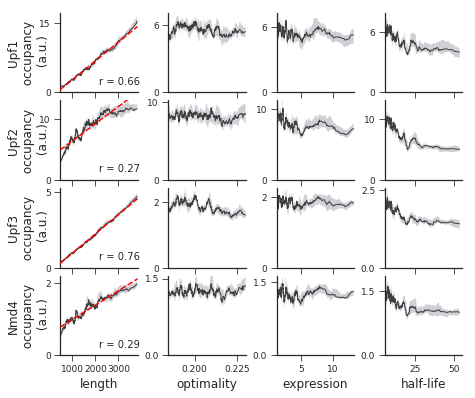

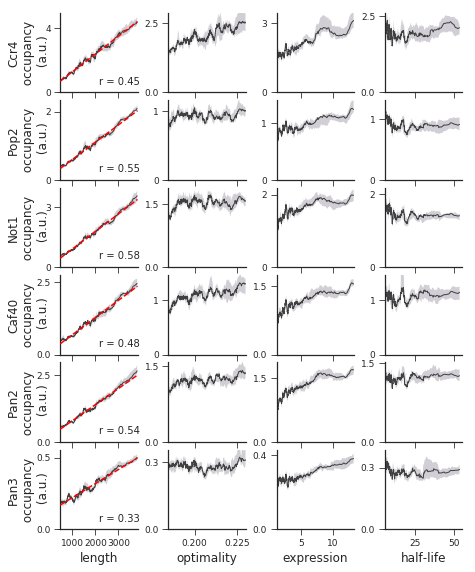

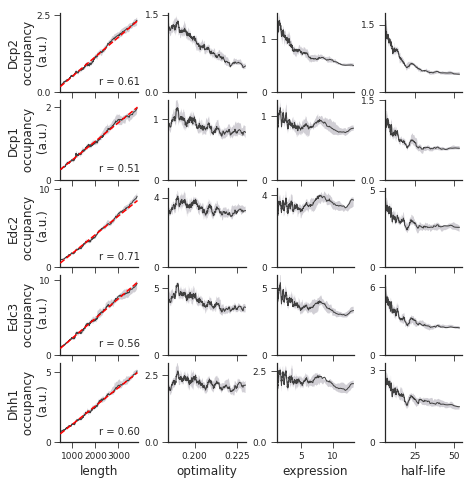

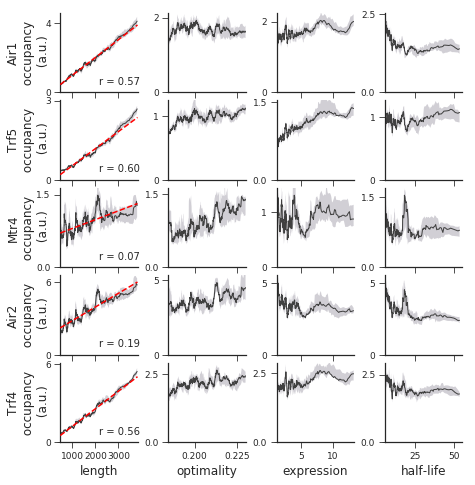

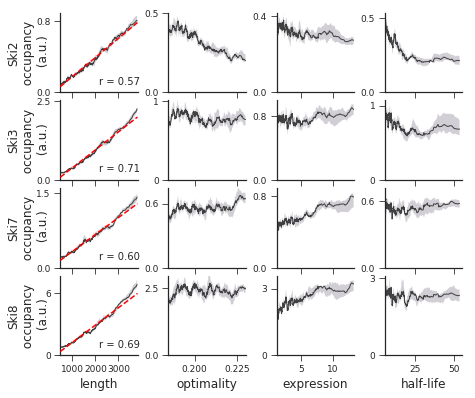

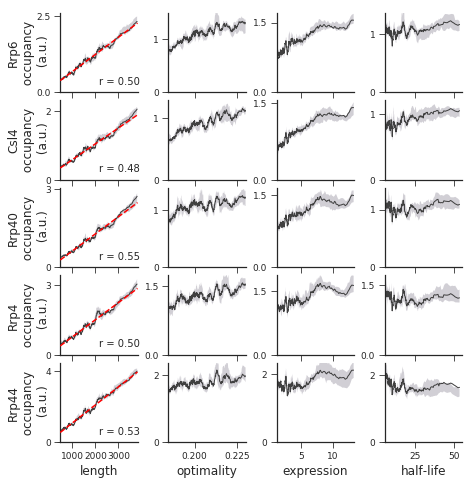

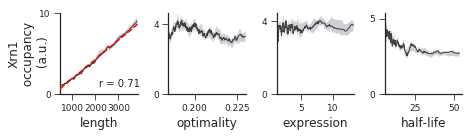

In [23]:
#supplementary figures

for pathway in pathways_of_interest:
    plot_line_pathway(pathway, pathway, 'supplement/features_%s.pdf' % pathway, lin_fit=True, bs=10, save_file=True)

### individual main figure subplots

In [24]:
def plot_line_final_fig(data_table, feature, title, plot_name, filter_pos=False, lin_fit=False, xlim=None, factors=None):
    
    if factors is None:
        factors = [['Dhh1', 'Dcp2', 'Xrn1'], ['Rrp44', 'Not1', 'Ccr4']]
    f,axes = plt.subplots(len(factors[0]), 2, sharex='col', facecolor='w', figsize=(3.5,1.6*(len(factors[0]))))
    plt.subplots_adjust(wspace = 0.5, hspace = 0.2)
    
    def plot_col(j):
        for i, factor in enumerate(factors[j]):
            
            low_int, high_int = bootstrap(data_table, factor, feature, sm=int(len(data_table)/40)*2 + 2, n=1000, ci=0.025)

            if filter_pos:
                #filter positive values
                data = [x for x in data_table[factor].values if (x>0)]

                pos_inx = data_table.loc[data_table[factor]>0,:].index
                feat = [data_table.loc[inx, feature] for inx in pos_inx]
            else:
                data = data_table[factor].values
                feat = data_table[feature].values

            smoothing_window = int(len(data)/40)*2 + 2
            med = running_mean(data,smoothing_window)

            ax1 = axes[i][j]

            if lin_fit:
                x=feat[int(smoothing_window/2):-int(smoothing_window/2)+1]
                fit = np.polyfit(x, med, 1)
                fit_fn = np.poly1d(fit) 
                # fit_fn is now a function which takes in x and returns an estimate for y
                plt.plot(x, fit_fn(x), '--r')

            ax1.plot(feat[int(smoothing_window/2):-int(smoothing_window/2)+1], med,
                     linewidth = 1, color = '#404040')
            ax1.fill_between(feat[int(smoothing_window/2):-int(smoothing_window/2)+1], low_int, high_int, facecolor='#D1CFD5', interpolate=True)
            #ax1.plot([0, feat[-int(smoothing_window/2)+1]], [0, max(med)], '-', lw=1, color = 'black')
            ax1.set_ylabel(factor, fontsize=10)



            ax1.tick_params(labelsize = 7)
            if xlim is None:
                ax1.set_xlim([feat[int(smoothing_window/2)],feat[-int(smoothing_window/2)+1]])
            else:
                ax1.set_xlim(xlim)
            ax1.set_ylim([0,max(med)*1.1])
            plt.locator_params(axis='y', nticks=3)
            ax1.get_yaxis().set_label_coords(-0.13,0.5)
            ax1.set_yticks([], [])
            ax1.spines['top'].set_visible(False)
            ax1.spines['right'].set_visible(False)
    
    plot_col(0)
    plot_col(1)

    plt.savefig(os.path.join(plotting_dir, plot_name), bbox_inches='tight')
    #plt.close()

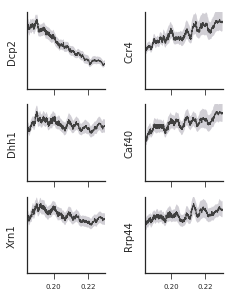

In [25]:
plot_line_final_fig(occupancy_by_optimality, feature='optimality', title='codon-optimality', plot_name='optimality/by_optimality_main.pdf',
                    filter_pos=False, lin_fit=False, factors=[['Dcp2','Dhh1','Xrn1'], [ 'Ccr4', 'Caf40', 'Rrp44']])

In [26]:
def plot_line_final_fig_column(data_table, feature, title, plot_name, filter_pos=False, lin_fit=False, xlim=None, factors=None):
    
    if factors is None:
        factors = ['Dcp2', 'Dcp1','Edc2', 'Edc3', 'Dhh1']
    f,axes = plt.subplots(len(factors), sharex='col', facecolor='w', figsize=(1.5,1.5*(len(factors))))
    
    plt.subplots_adjust(wspace = 0.6, hspace = 0.15)
    for i, factor in enumerate(factors):
        
        low_int, high_int = bootstrap(data_table, factor, feature, sm=int(len(data_table)/40)*2 + 2, n=1000, ci=0.025)

        if filter_pos:
            #filter positive values
            data = [x for x in data_table[factor].values if (x>0)]

            pos_inx = data_table.loc[data_table[factor]>0,:].index
            feat = [data_table.loc[inx, feature] for inx in pos_inx]
        else:
            data = data_table[factor].values
            feat = data_table[feature].values

        smoothing_window = int(len(data)/40)*2 + 2
        med = running_mean(data,smoothing_window)

        ax1 = axes[i]

        if feature=='length' and lin_fit:
            #linear fit
            x=feat[int(smoothing_window/2):-int(smoothing_window/2)+1]

            if False:  #dock the line at 0,0
                matrix = np.stack([x], axis=-1)   # stack them like columns
                coeff = np.linalg.lstsq(matrix, med)[0] 

                model, resid = np.linalg.lstsq(matrix, med)[:2]

                ax1.plot(x, coeff*x, '--r', zorder=20)
                r = corrfunc(data, feat)
                ax1.text(0.5, 0.1, "r = {:.2f}".format(r),
                    transform=ax1.transAxes)

            if True: #no constraint for the linear fit
                fit = np.polyfit(x, med, 1)
                fit_fn = np.poly1d(fit) 
                # fit_fn is now a function which takes in x and returns an estimate for y
                ax1.plot(x, fit_fn(x), '--r', zorder=20)
                r = corrfunc(data, feat)
                ax1.text(0.5, 0.1, "r = {:.2f}".format(r),
                    transform=ax1.transAxes)


            
        if feature=='halflife' and lin_fit:
            x=feat[int(smoothing_window/2):-int(smoothing_window/2)+1]
            
            def func2(t, a, b):
                return ((a/t) + b)

            popt, pcov = curve_fit(func2, x, med)
            print(popt[0]/popt[1])
            ax1.plot(x, [func2(xd, popt[0], popt[1]) for xd in x], '--r', zorder=15, lw=1)
            ax1.plot(x, [popt[1] for xd in x], color='grey', ls='--', zorder=2)
            ax1.text(0.2, 0.9, "a/b = {:.1f}".format(popt[0]/popt[1]),
                transform=ax1.transAxes)
            ax1.text(0.5, 0.1, "b", transform=ax1.transAxes)

        ax1.plot(feat[int(smoothing_window/2):-int(smoothing_window/2)+1], med,
                 linewidth = 1, color = '#404040', zorder=10)
        ax1.fill_between(feat[int(smoothing_window/2):-int(smoothing_window/2)+1], low_int, high_int, facecolor='#D1CFD5', interpolate=True)
        ax1.set_ylabel(factor, fontsize=13)

        ax1.tick_params(labelsize = 7)
        if xlim is None:
            ax1.set_xlim([feat[int(smoothing_window/2)],feat[-int(smoothing_window/2)+1]])
        else:
            ax1.set_xlim(xlim)
        ax1.set_ylim([0,max(med)*1.1])
        plt.locator_params(axis='y', nticks=3)
        ax1.get_yaxis().set_label_coords(-0.5,0.5)
        ax1.set_yticks([], [])
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)

    plt.savefig(os.path.join(plotting_dir, plot_name), bbox_inches='tight')
    #plt.close()

18.7476441166
7.40543032158
4.36357949419
9.0783675242
4.70593006313


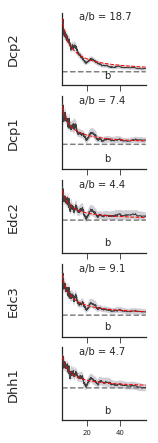

In [27]:
plot_line_final_fig_column(occupancy_by_halflife, feature='halflife', title='half-life', plot_name='half_life/by_halflife_main.pdf',
                    filter_pos=False, lin_fit=True)

### feature importance analysis (linear regression)

In [28]:
#filter a 90% interval

occupancy2 = occupancy.loc[(occupancy.halflife>start.halflife) & (occupancy.halflife<end.halflife)]
occupancy2 = occupancy2.loc[(occupancy.optimality>start.optimality) & (occupancy.optimality<end.optimality)]
occupancy2 = occupancy2.loc[(occupancy.coverage>start.coverage) & (occupancy.coverage<end.coverage)]

occupancy_div_length = occupancy2.copy()
occupancy_div_length = occupancy_div_length.select_dtypes([np.number])
occupancy_div_length.iloc[:,:-5] = occupancy_div_length.iloc[:,:-5].div(occupancy2.length.values, axis=0)
occupancy_div_length.to_csv(os.path.join(plotting_dir, 'occupancy_divLength.txt'), sep='\t', index=False)

In [29]:
pathways_of_interest = ['Deadenylation', 'Decapping', 'Xrn1', 'Exosome', 'TRAMP', 'Ski',  'NMD']
data_summary.rename(index={'Nam7':'Upf1', 'Nmd2':'Upf2'}, inplace=True)
data_summary.factor = data_summary.index 

factors = data_summary.loc[data_summary.pathway.isin(pathways_of_interest), 'factor']

#### linear regression was performed in R (see linear_regression.R)

In [30]:
#load the output from linear_regression.R
pvals = pd.read_csv(os.path.join(plotting_dir, 'pvalues_filteredvalues.txt'), sep='\t', index_col=0)
pvals = pvals.loc[['length', 'optimality', 'expression', 'half-life'], factors]

#### Figure 6C: p-values

In [31]:
occupancy = occupancy.dropna()
occupancy_l = occupancy.loc[:,factors].div(occupancy.length, axis=0)
attrs = occupancy.columns[-5:-1]
pvals_sign = pd.DataFrame(columns=factors, index=attrs)
for fac in factors:
    for attr in attrs:
        if attr is 'optimality':
            occupancy2 = occupancy_by_optimality
        elif attr is 'halflife':
            occupancy2 = occupancy_by_halflife
        elif attr is 'coverage':
            occupancy2 = occupancy_by_expression
        else:
            occupancy2 = occupancy_by_length
            
        pvals_sign.loc[attr, fac] = 1 if pearsonr(occupancy2.loc[:,fac], occupancy2.loc[:,attr])[0]>0 else -1
pvals_sign.index = ['length', 'half-life', 'expression', 'optimality']

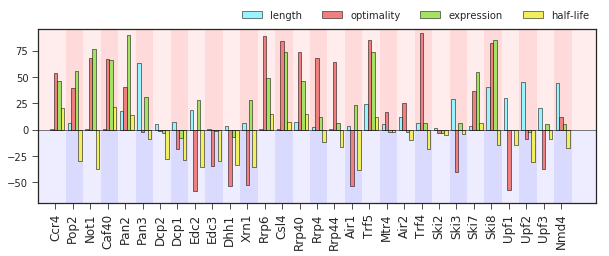

In [32]:
import matplotlib.collections as collections

ymin = -70
ymax = +95
x = np.arange(1,len(pvals.columns)+1)
plt.subplots(figsize=(10,3.2))
ax = plt.subplot(111)
colors = ['#98F5FF', '#F08080', '#a3e263', '#f2ef5e']
barkw = dict(width=0.2, align='center', edgecolor='k', linewidth=0.5)
b1 = ax.bar(x-0.2, pvals_sign.loc['length',]*pvals.loc['length',],color=colors[0], **barkw)
b2 = ax.bar(x, pvals_sign.loc['optimality',]*pvals.loc['optimality',],color=colors[1], **barkw)
b3 = ax.bar(x+0.2, pvals_sign.loc['expression',]*pvals.loc['expression',],color=colors[2], **barkw)
b4 = ax.bar(x+0.4, pvals_sign.loc['half-life',]*pvals.loc['half-life',],color=colors[3], **barkw)

xt=plt.xticks(x, pvals.columns, rotation=90, fontsize=12)
lgd = ax.legend( (b1[0], b2[0], b3[0], b4[0]), ('length', 'optimality', 'expression', 'half-life'),
         bbox_to_anchor=(.35,1.), frameon=False, ncol=4, loc=3)

if True:
    for i in range(int(len(factors)/2)):
        c1 = collections.BrokenBarHCollection([(x[i*2+1]-0.4, 1)], (0,ymax), facecolor='red', alpha=0.08)
        c2 = collections.BrokenBarHCollection([(x[i*2+1]-0.4, 1)], (ymin,abs(ymin)), facecolor='blue', alpha=0.08)
        ax.add_collection(c1)
        ax.add_collection(c2)

c1 = collections.BrokenBarHCollection([(-3, 50)], (0,ymax), facecolor='red', alpha=0.07)
c2 = collections.BrokenBarHCollection([(-3, 50)], (ymin,abs(ymin)), facecolor='blue', alpha=0.07)
ax.add_collection(c1)
ax.add_collection(c2)
ax.set_xlim(-0.01,)
ax.set_ylim(ymin, ymax)
ax.hlines([0], *ax.get_xlim(), linewidth=0.5)
#plt.savefig(os.path.join(plotting_dir, 'importance.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

#### Figure 6--supplemantry figure9: correlation values
occupancy is not divide by length here

In [33]:
occupancy = occupancy.dropna()
occupancy_l = occupancy.loc[:,factors].div(occupancy.length, axis=0)
attrs = occupancy.columns[-5:-1]
pvals_sign = pd.DataFrame(columns=factors, index=attrs)
for fac in factors:
    for attr in attrs:
        if attr is 'optimality':
            occupancy2 = occupancy_by_optimality
        elif attr is 'halflife':
            occupancy2 = occupancy_by_halflife
        elif attr is 'coverage':
            occupancy2 = occupancy_by_expression
        else:
            occupancy2 = occupancy_by_length
            
        pvals_sign.loc[attr, fac] = stats.pearsonr(occupancy2.loc[:,fac], occupancy2.loc[:,attr])[0]
pvals_sign.index = ['length', 'half-life', 'expression', 'optimality']

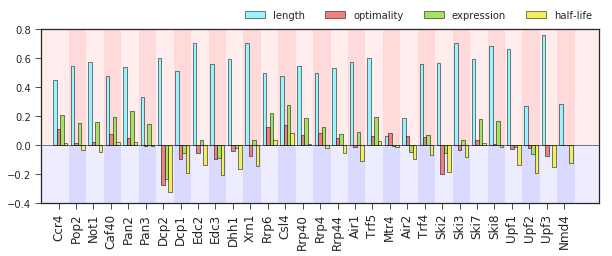

In [34]:
import matplotlib.collections as collections

ymin = -0.4
ymax = +0.8
x = np.arange(1,len(pvals_sign.columns)+1)
plt.subplots(figsize=(10,3.2))
ax = plt.subplot(111)
colors = ['#98F5FF', '#F08080', '#a3e263', '#f2ef5e']
barkw = dict(width=0.2, align='center', edgecolor='k', linewidth=0.5)
b1 = ax.bar(x-0.2, pvals_sign.loc['length',],color=colors[0], **barkw)
b2 = ax.bar(x, pvals_sign.loc['optimality',],color=colors[1], **barkw)
b3 = ax.bar(x+0.2, pvals_sign.loc['expression',],color=colors[2], **barkw)
b4 = ax.bar(x+0.4, pvals_sign.loc['half-life',],color=colors[3], **barkw)

xt=plt.xticks(x, pvals_sign.columns, rotation=90, fontsize=12)
lgd = ax.legend( (b1[0], b2[0], b3[0], b4[0]), ('length', 'optimality', 'expression', 'half-life'),
         bbox_to_anchor=(.35,1.), frameon=False, ncol=4, loc=3)

if True:
    for i in range(int(len(factors)/2)):
        c1 = collections.BrokenBarHCollection([(x[i*2+1]-0.4, 1)], (0,ymax), facecolor='red', alpha=0.08)
        c2 = collections.BrokenBarHCollection([(x[i*2+1]-0.4, 1)], (ymin,abs(ymin)), facecolor='blue', alpha=0.08)
        ax.add_collection(c1)
        ax.add_collection(c2)

c1 = collections.BrokenBarHCollection([(-3, 50)], (0,ymax), facecolor='red', alpha=0.07)
c2 = collections.BrokenBarHCollection([(-3, 50)], (ymin,abs(ymin)), facecolor='blue', alpha=0.07)
ax.add_collection(c1)
ax.add_collection(c2)
ax.set_xlim(-0.01,)
ax.set_ylim(ymin, ymax)
ax.hlines([0], *ax.get_xlim(), linewidth=0.5)
#plt.savefig(os.path.join(plotting_dir, 'correlation.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()